# Part 1

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier 

In [136]:
# Opening JSON file
with open('logins.json') as f:
    d = json.load(f)
    print(d)

{'login_time': ['1970-01-01 20:13:18', '1970-01-01 20:16:10', '1970-01-01 20:16:37', '1970-01-01 20:16:36', '1970-01-01 20:26:21', '1970-01-01 20:21:41', '1970-01-01 20:12:16', '1970-01-01 20:35:47', '1970-01-01 20:35:38', '1970-01-01 20:47:52', '1970-01-01 20:26:05', '1970-01-01 20:31:03', '1970-01-01 20:34:46', '1970-01-01 20:36:34', '1970-01-01 20:39:25', '1970-01-01 20:40:37', '1970-01-01 20:34:58', '1970-01-01 20:43:59', '1970-01-01 20:47:46', '1970-01-01 20:46:34', '1970-01-01 20:56:07', '1970-01-01 20:49:12', '1970-01-01 20:59:06', '1970-01-01 20:59:59', '1970-01-01 21:15:01', '1970-01-01 21:09:24', '1970-01-01 21:19:24', '1970-01-01 21:20:53', '1970-01-01 21:29:19', '1970-01-01 21:58:05', '1970-01-01 21:51:51', '1970-01-01 21:59:40', '1970-01-01 22:08:34', '1970-01-01 22:02:51', '1970-01-01 21:58:32', '1970-01-01 22:02:31', '1970-01-01 22:05:32', '1970-01-01 22:02:46', '1970-01-01 22:10:28', '1970-01-01 22:11:58', '1970-01-01 22:01:05', '1970-01-01 22:19:10', '1970-01-01 22:16:

In [137]:
#create dataframe
df = pd.DataFrame(d)
print(df.head())
print(df.columns)
df.dtypes

            login_time
0  1970-01-01 20:13:18
1  1970-01-01 20:16:10
2  1970-01-01 20:16:37
3  1970-01-01 20:16:36
4  1970-01-01 20:26:21
Index(['login_time'], dtype='object')


login_time    object
dtype: object

In [138]:
df['login_time'] = pd.to_datetime(df['login_time'])

In [139]:
df.set_index('login_time', inplace=True)

In [140]:
#creating new column to count number of logins per 15 minute periods
df['count'] = 1
df.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [141]:
df_15min= df.resample('15T').count()

In [142]:
df_15min.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


From the plot below, can see there seems to some type of pattern of highs and lows. 

## Plot 1 - 15 min intervals

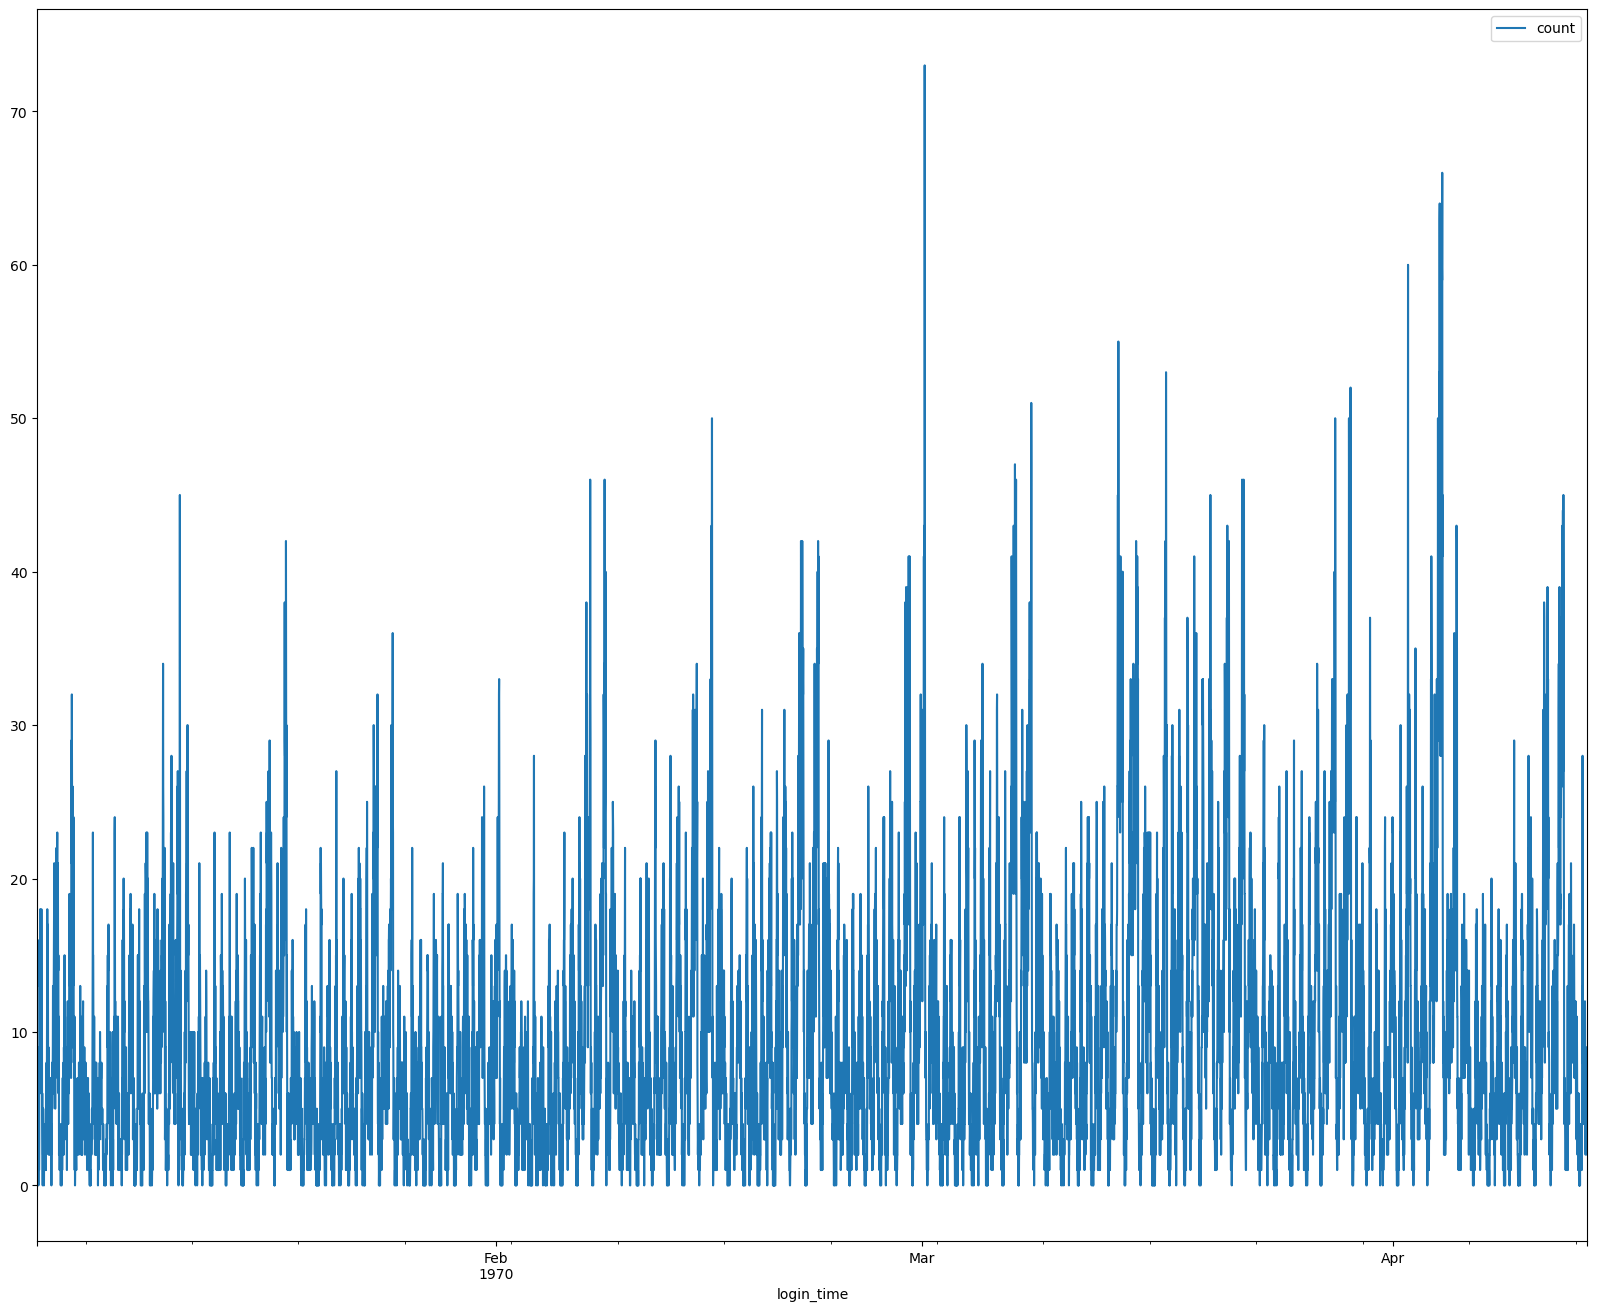

In [143]:
df_15min.plot(figsize = (20, 16))
plt.show()

## Plot 2 

Using the 15 minute interval then plotting what one week looks like. There are 96-15 minute time intervals in a day. There is 672- 15 minute time intervals in a week. 

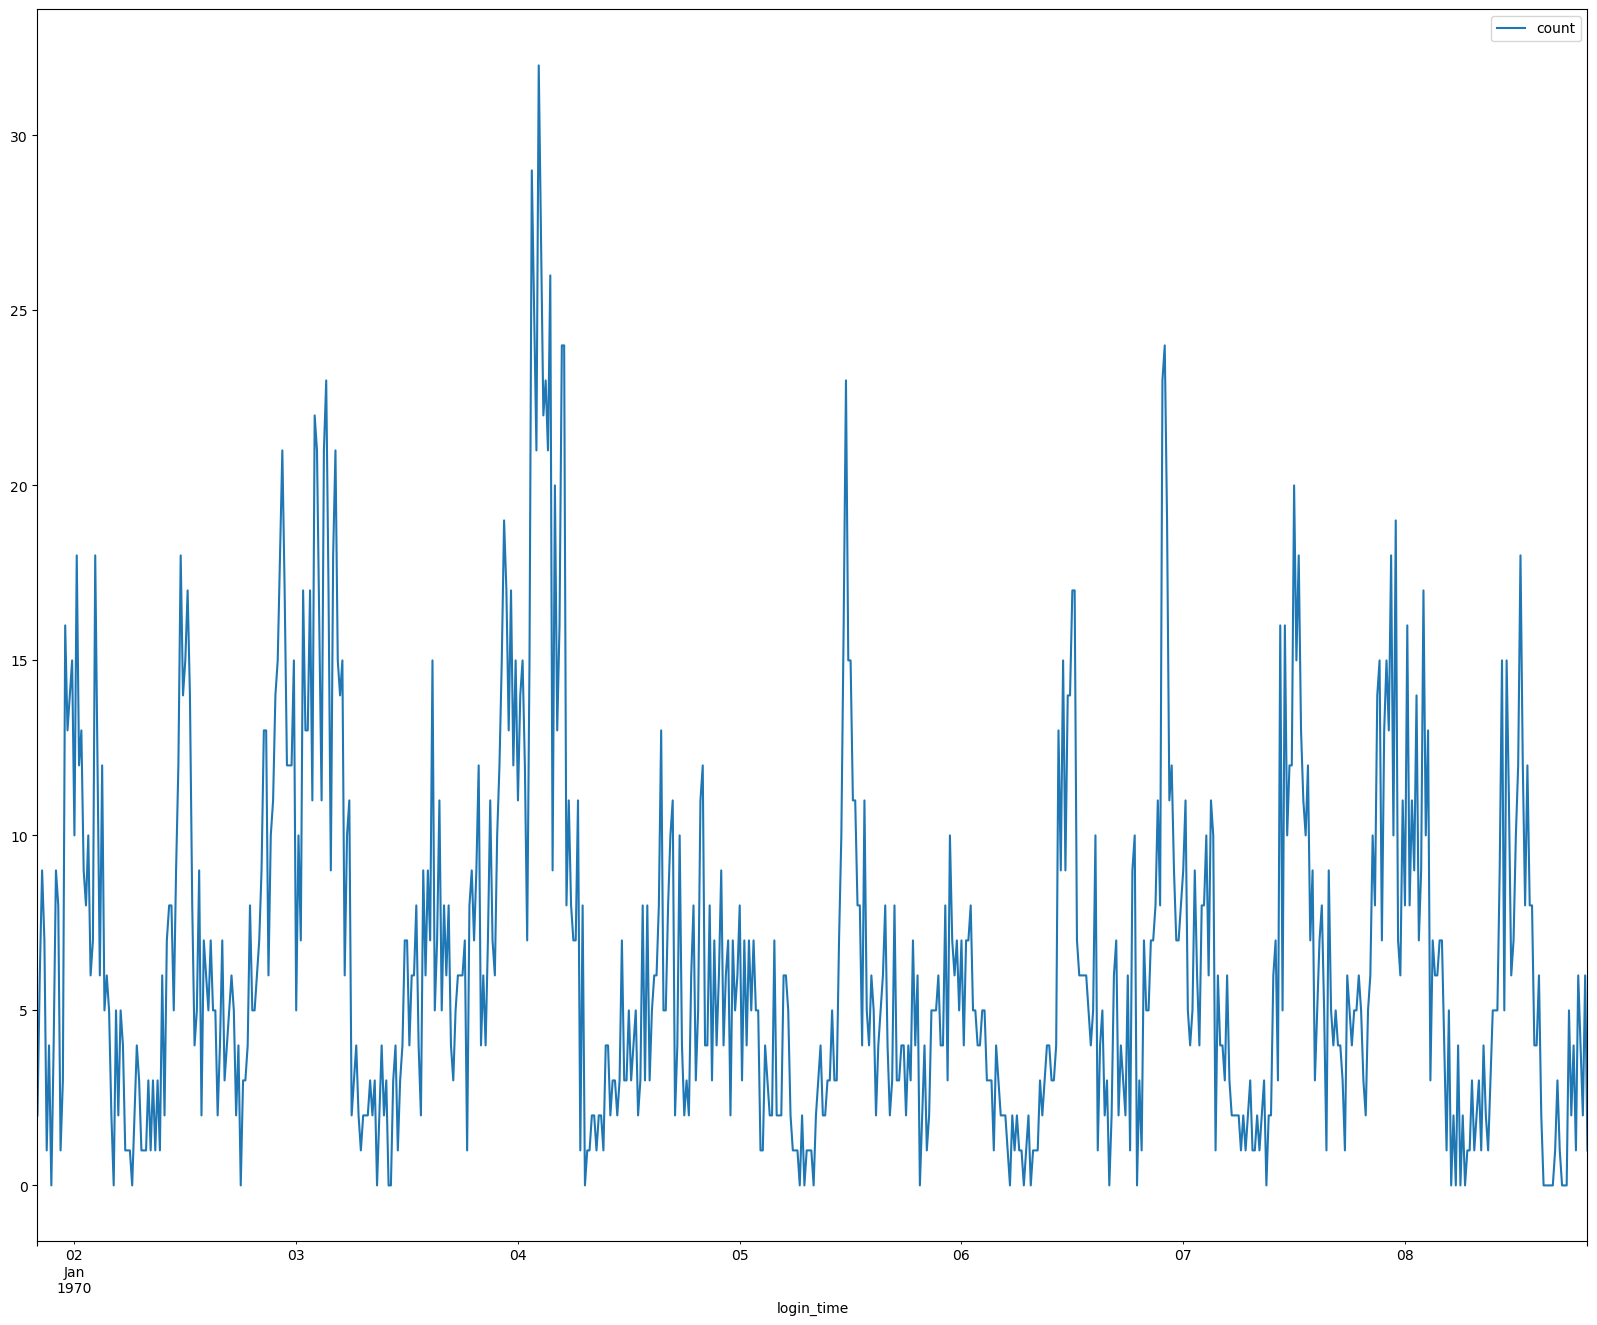

In [144]:
df_15min[0:672].plot(figsize = (20, 16))
plt.show()

## Plot 3

In [145]:
#login count per day to then plot that
df_1day = df.resample('1D').count()

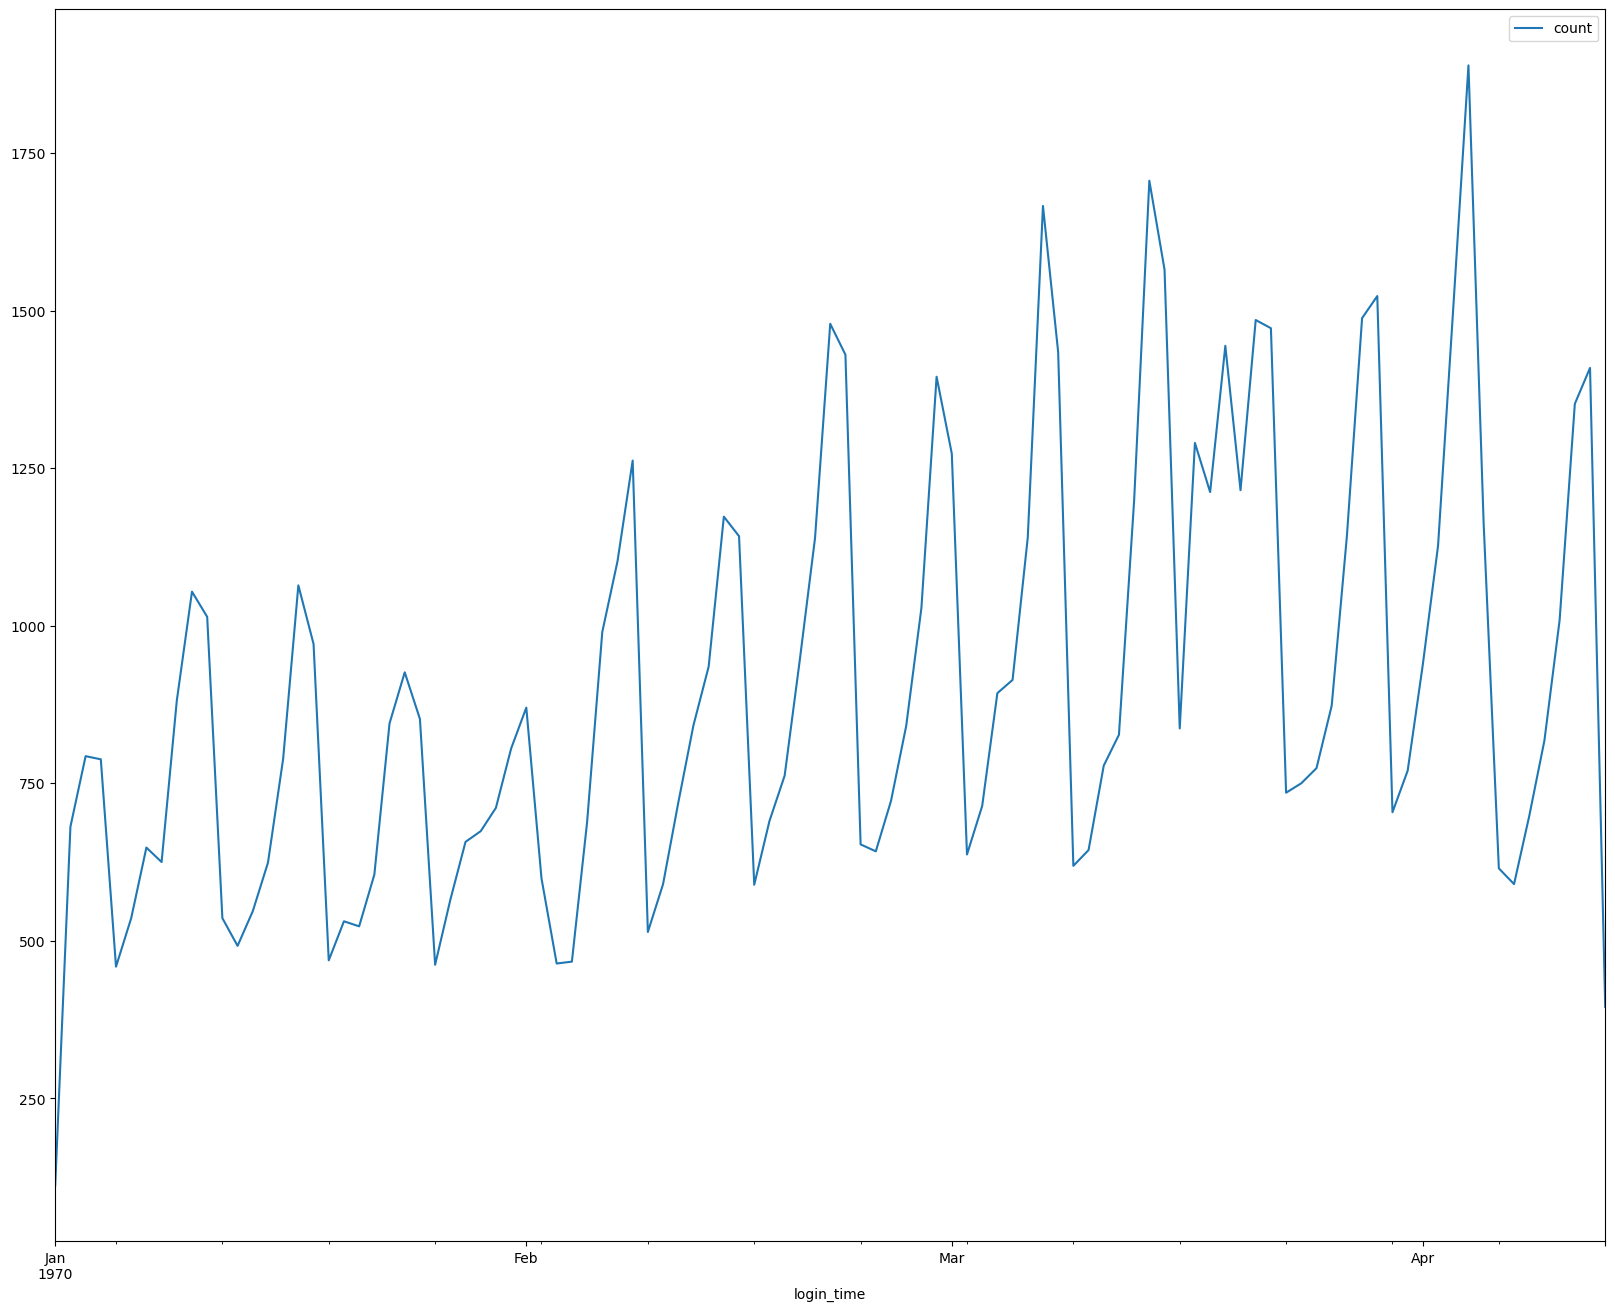

In [146]:
#plotting login count per day 
df_1day.plot(figsize = (20, 16))
plt.show()

## Plot 4 - Looking at daily login trend 

In [161]:
# Extracting day of the week as a new column to help determine what days show the peaks
df_1day['day_of_week'] = df_1day.index.strftime('%A')
df_1day.head()

,count,day_of_week
login_time,,
1970-01-01,112,Thursday
1970-01-02,681,Friday
1970-01-03,793,Saturday
1970-01-04,788,Sunday
1970-01-05,459,Monday


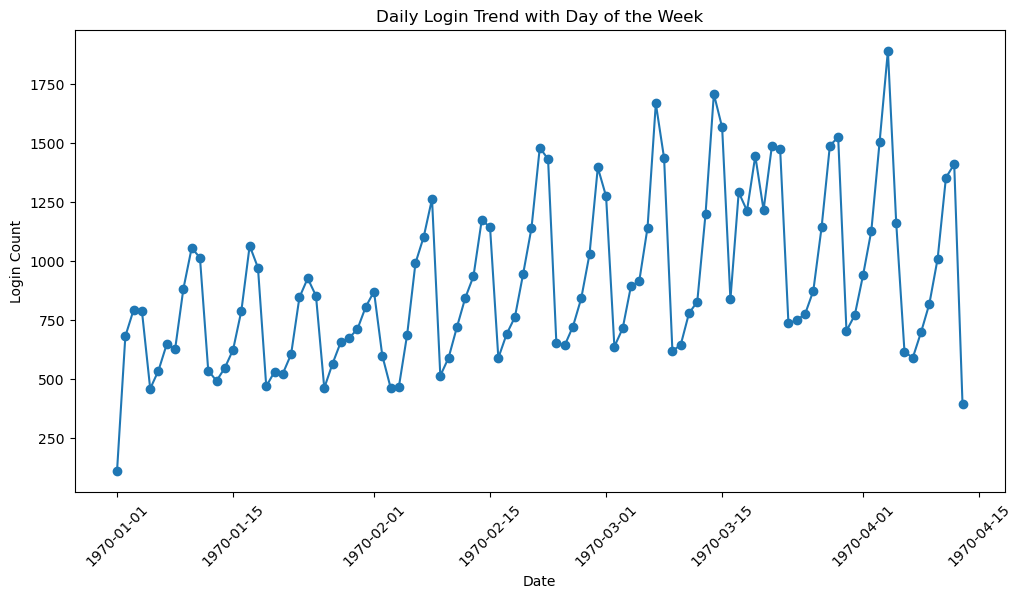

In [160]:
# Plotting with day of the week on x-axis
plt.figure(figsize=(12, 6))
plt.plot(df_1day.index, df_1day['count'], marker='o')
plt.title('Daily Login Trend with Day of the Week')
plt.xlabel('Date')
plt.ylabel('Login Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

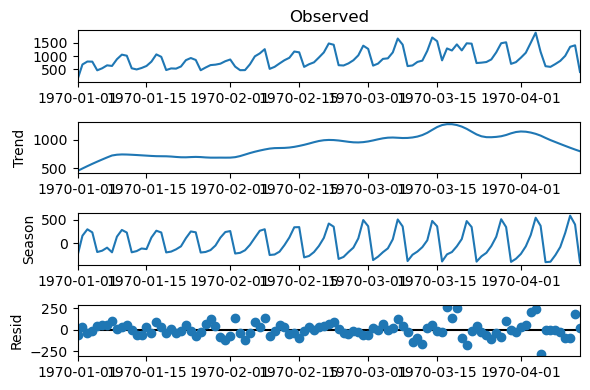

In [154]:
from statsmodels.tsa.seasonal import STL
result = STL(df.resample('1D').count()).fit()

# Plot the decomposition components
result.plot()
plt.show()

## Plot 5 - ACF

From the acf plot, can see a strong positive autocorrelation at lags (7, 8, 9) and (14, 15, 16) and (21, 22, 23) and (28, 29 , 30). This is supporting the weekend usage. 

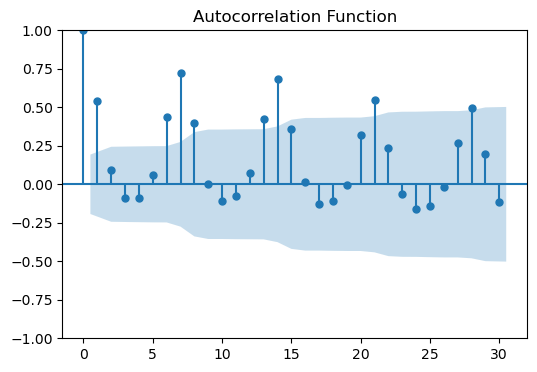

In [157]:
from statsmodels.graphics.tsaplots import plot_acf

# Calculate autocorrelation function
acf_result = plot_acf((df.resample('1D').count()), lags=30)
plt.title('Autocorrelation Function')
plt.show()

From the plots above, can notice a few things. 
1. There is some seasonality to the data as see 4/5 peaks within a month (Plot 3 and 4).
2. The highest peak days in the data are on the weekend - Friday, Saturday, Sunday. See this in Plot 4. Plot 6 supports this and shows a strong positive correction. This supports why seeing 4/5 peaks within a month. 
3. There is an upward trend that then goes seems to go slightly downward. (see subplot 'Trend' below).
    

# Part 2 - Experiment and metrics design

In [ ]:
The situation:
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a) how you will implement the experiment
b) what statistical test(s) you will conduct to verify the significance of the observation
c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

1. Key Measure: Look to measure the percentage of trips across the toll bridge. 
   a. Measure the percentage of trips across the toll bridge for a given time before the incentive took place. 
   b. Measure the percentage of trips across the toll bridge for the same given time when the incentive is in
      place where there is reimbursement of the toll bridge. 
   c. This measure would be a good metric to see if the incentive of the reimbursement has any effect on
      the trips done by the drivers as they specifically want to look to see if there is an increase in
      trips going across the bridge.
   
2. Experiment:
   a. Data:
         i. Gather the data on number of trips and number of trips across the toll bridge for a given time period
            before the reimbursement policy takes effect. 
        ii. Implement the reimbursement policy and confirm that all drivers know of new policy change. 
        iii. Gather data on number of trips and number of trips across the toll bridge for the same given
             time period as before the policy. 
    b. Test: A paired t-test to compare the two data sets collected. 
        i. Null hypothesis: There is no significant difference in the number of trips going across the bridge after
           the policy change. 
        ii. Alternative hypothesis: There is significant difference in the number of trips going across the bridge
           after the policy change. 
    c. Results:
        i. Fail to reject the null hypothesis: If there is no significant difference, then would look at other
           incentives or evaluate why there is no change.  
        ii. Reject the null hypothesis: If there is a significant difference between the number of trips going
           across the bridge after policy change, then would suggest that would keep the policy of the reimbursement.

Caveats could be overall traffic, looking into does a driver make more if he/she drives over the bridge for trips or make more by staying in one city. 




# Part 3

## 1. Load Data

In [23]:
# Open the file in read mode
file_path ='ultimate_data_challenge.json'
with open(file_path, 'r') as file:
    # Read the file by line (chunks) 
    for line in file:
        data = json.loads(line)

In [28]:
#create dataframe
df1 = pd.DataFrame(data)
print(df1.head())

             city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   

## 2. Data Wrangling

In [34]:
df1.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [35]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [36]:
df1.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [51]:
print(df1.phone.value_counts())
print(df.phone.mode().iloc[0])


iPhone     34582
Android    15022
Name: phone, dtype: int64
iPhone


In [54]:
#fill na values

#fill in na values with average for 'avg_rating_of_driver'
avg_rating= df1.avg_rating_of_driver.mean()
df1['avg_rating_of_driver'] = df1['avg_rating_of_driver'].fillna(avg_rating)

#fill in na values with average for 'avg_rating_by_driver'
avg_rating_by_driver= df1.avg_rating_by_driver.mean()
df1.avg_rating_by_driver= df1.avg_rating_by_driver.fillna(avg_rating_by_driver)

#fill na values for phone with mode -- 'iPhone'
mode_value = df1['phone'].mode()[0]

df1['phone'].fillna(mode_value, inplace=True)
#confirm that values count for 'iPhone' increased for iPhone
print(df1.phone.value_counts())

df1.isna().sum()

iPhone     34978
Android    15022
Name: phone, dtype: int64


city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [56]:
df1[['signup_date', 'last_trip_date']]= df1[['signup_date', 'last_trip_date']].apply(pd.to_datetime)
df1.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [58]:
print(df1.signup_date.min())
df1.last_trip_date.max()

2014-01-01 00:00:00


Timestamp('2014-07-01 00:00:00')

## 3. EDA

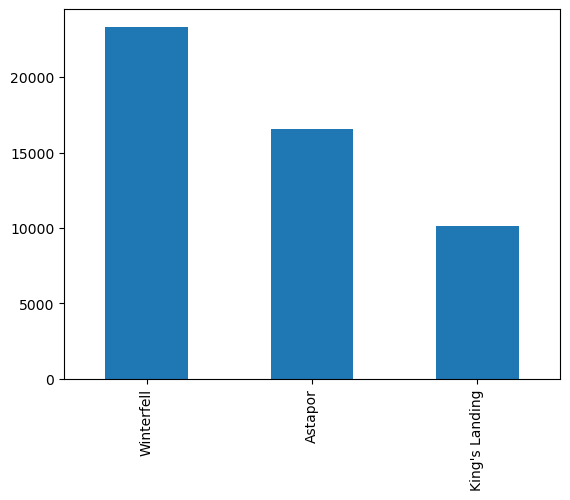

In [55]:
df1.city.value_counts().plot(kind='bar')
plt.show()

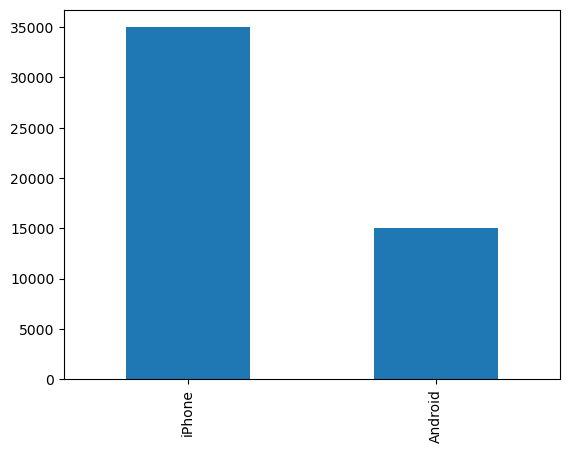

In [59]:
df1.phone.value_counts().plot(kind='bar')
plt.show()

Wanting to see a quick visual to see the difference in percentage of users active within first 30 days and
last 30 days before collection. 

1    0.6922
0    0.3078
Name: active, dtype: float64

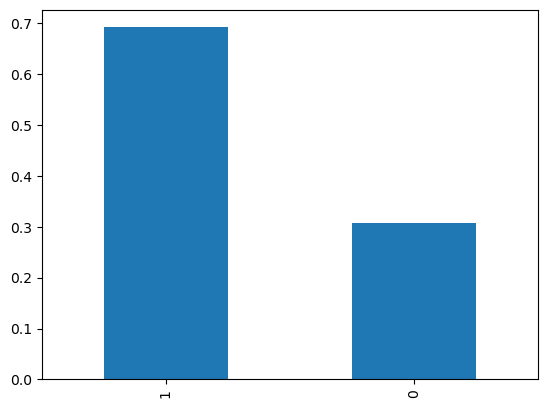

In [75]:
#looking at how active users were in first 30 days to then compare to how many active users for last 30 days before colllection
df1['active']= df1.trips_in_first_30_days.apply(lambda x: 1 if x> 0 else 0)

df1.active.value_counts(normalize=True).plot(kind='bar')
df1.active.value_counts(normalize=True)

In [73]:
#considered active in active within last 30 days up to collection
df1['retained'] = (df1['last_trip_date'] > '2014-06-01').astype(int)


From the bar plot below and counts, the data shows that 36.62 were retained and 63.38 were not retained. 

0    0.6338
1    0.3662
Name: retained, dtype: float64

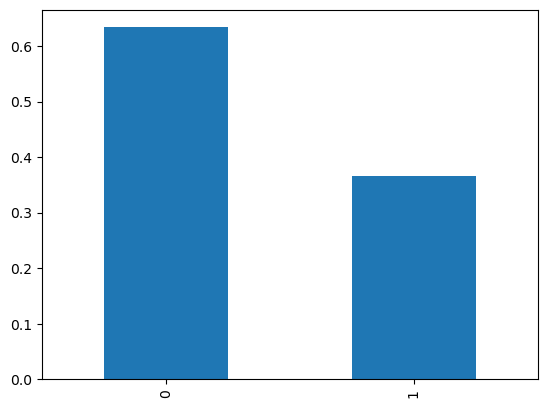

In [74]:
df1.retained.value_counts(normalize=True).plot(kind='bar')
df1.retained.value_counts(normalize=True)

In [76]:
df1.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'active', 'retained'],
      dtype='object')

In [77]:
df1.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
active                             int64
retained                           int64
dtype: object

## 4. Preprocessing

Next steps:
1. Change object and bool columns to one hot encoded columns using pandas get_dummies function
2. Create X matrix containing features for model and y as the target.
3. Undersample the majority to balance the two classes (retained as 1 and not retained as 0)
4. Split the data into training and testing sets.

In [78]:
#create one hot encoding on three columns: city, phone, ultimate_black_user
one_hot_encoded_data = pd.get_dummies(df1, columns = ['city', 'phone', 'ultimate_black_user']) 
print(one_hot_encoded_data)

       trips_in_first_30_days signup_date  avg_rating_of_driver  avg_surge  \
0                           4  2014-01-25              4.700000       1.10   
1                           0  2014-01-29              5.000000       1.00   
2                           3  2014-01-06              4.300000       1.00   
3                           9  2014-01-10              4.600000       1.14   
4                          14  2014-01-27              4.400000       1.19   
...                       ...         ...                   ...        ...   
49995                       0  2014-01-25              5.000000       1.00   
49996                       1  2014-01-24              4.601559       1.00   
49997                       0  2014-01-31              5.000000       1.00   
49998                       2  2014-01-14              3.000000       1.00   
49999                       0  2014-01-18              4.601559       1.00   

      last_trip_date  surge_pct  weekday_pct  avg_dist  avg_rat

In [88]:
#confirm changes were made
print(one_hot_encoded_data.dtypes)

trips_in_first_30_days                int64
signup_date                  datetime64[ns]
avg_rating_of_driver                float64
avg_surge                           float64
last_trip_date               datetime64[ns]
surge_pct                           float64
weekday_pct                         float64
avg_dist                            float64
avg_rating_by_driver                float64
active                                int64
retained                              int64
city_Astapor                          uint8
city_King's Landing                   uint8
city_Winterfell                       uint8
phone_Android                         uint8
phone_iPhone                          uint8
ultimate_black_user_False             uint8
ultimate_black_user_True              uint8
dtype: object


In [84]:
#removing the dates, 'signup_date' and 'last_trip_date', to prepare it for modeling
data = one_hot_encoded_data[['trips_in_first_30_days', 'avg_rating_of_driver',
       'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'active', 'retained', 'city_Astapor', "city_King's Landing", 'city_Winterfell', 'phone_Android',
       'phone_iPhone', 'ultimate_black_user_False',
       'ultimate_black_user_True']]

In [85]:
#X is a matrix of features and y is the target variable
X = data.drop('retained', axis= 1)
y = data[['retained']]

In [86]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [87]:
y_resampled.value_counts()

retained
0           18310
1           18310
dtype: int64

In [99]:
type(y_resampled)

pandas.core.frame.DataFrame

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=47)

## 5. Modeling

### Model 1 - Logistic Regression

In [108]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16, max_iter=1000)

# fit the model with data
logreg.fit(X_train, y_train.values.ravel())

y_pred = logreg.predict(X_test)

In [109]:
print('Model 1- Logistic Regression- ROC AUC score: {0:0.4f}'. format(roc_auc_score(y_test, y_pred)))

Model 3 ROC AUC score: 0.6977


### Model 2 - Random Forest

In [110]:
model_2 = RandomForestClassifier()   
  
# Train the model
model_2.fit(X_train, y_train.values.ravel()) 
  
# Make y predictions on the X_test data
y_pred = model1.predict(X_test) 
  
# using metrics module for accuracy calculation 
print("Model 2 ROC AUC score {0:0.4f} : ", roc_auc_score(y_test, y_pred)) 

Model 2 ROC AUC score {0:0.4f} :  0.745045974817254


### Model 3 - Random Forest with Grid Search

In [100]:
#use Grid search on Random Forest model
param_grid = { 
    'n_estimators': [50, 100, 150, 200], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [4, 8, 12], 
    'max_leaf_nodes': [4, 8, 12], 
} 

In [101]:
#train model on different parameters using grid search to find a better model
model3 = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid) 
model3.fit(X_train, y_train.values.ravel()) 
print(model3.best_estimator_)

RandomForestClassifier(max_depth=8, max_leaf_nodes=12)


In [112]:
#use best parameters from GridSearch above
model3_best = RandomForestClassifier(max_depth=8, 
                                    max_leaf_nodes=12, 
                                    n_estimators=50) 
model3_best.fit(X_train, y_train.values.ravel()) 

RandomForestClassifier(max_depth=8, max_leaf_nodes=12, n_estimators=50)

In [113]:
#predict y values from X_test set
y_pred3 = model3_best.predict(X_test)

#determine accuracy of model using actual y_test values and predicted y_pred values
print('Model 3 ROC AUC score: {0:0.4f}'. format(roc_auc_score(y_test, y_pred2)))

Model 3 ROC AUC score: 0.7532


In [114]:
def display_confusion_matrix(ytest, ypred, model) :
    cm = confusion_matrix(ytest, ypred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels =[1,0])
    disp.plot()
    plt.show()
def class_report(ytest, ypred) :
    print(classification_report(ytest, ypred))

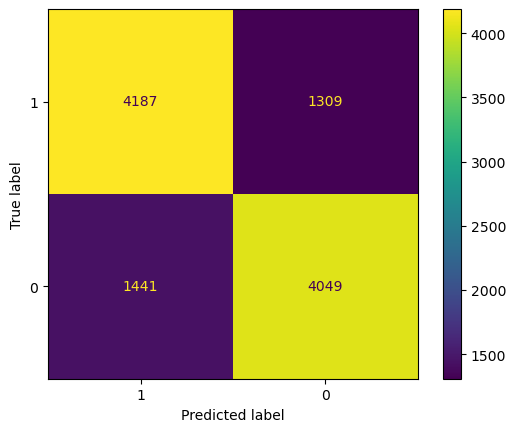

              precision    recall  f1-score   support

           0       0.74      0.76      0.75      5496
           1       0.76      0.74      0.75      5490

    accuracy                           0.75     10986
   macro avg       0.75      0.75      0.75     10986
weighted avg       0.75      0.75      0.75     10986



In [115]:
display_confusion_matrix(y_test, y_pred3, model3_best)

class_report(y_test, y_pred3)

### Model 4 - XGBoost with Grid Search

In [118]:
#set estimator
estimator = XGBClassifier(
    objective= 'binary:logistic',
    seed=42
)

In [119]:
#set parameters 
parameters = {
    'max_depth': range (4, 8, 2),
    'n_estimators': range(80, 180, 40),
    'learning_rate': [0.2, 0.4],  
    'min_child_weight' : range(2, 5, 1),
    'colsample_bytree': [0.2, 0.4]
}


In [120]:
#grid search with the different parameters listed above 5 cross validations
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    #how many cpus using- set to -1 to use them all
    n_jobs = -1,
    cv = 5
)

In [122]:
#fit the grid search on the X_train and y_train data of the Undersampling data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.2, 0.4],
                         'learning_rate': [0.2, 0.4],
                         'max_depth': range(4, 8, 2),
                         'min_child_weight': range(2, 5),
                         'n_estimators': range(80, 180, 40)},
             scoring='roc_auc')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=160, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Model 4 ROC AUC score: 0.7798


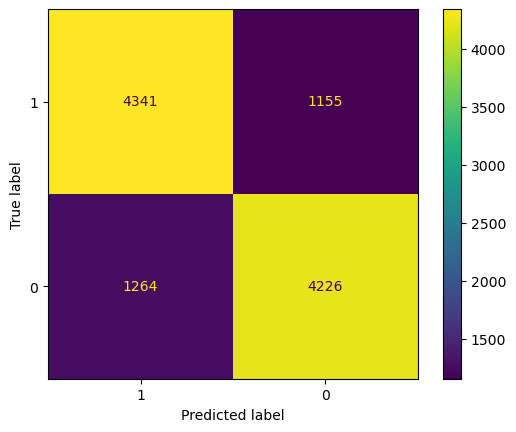

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      5496
           1       0.79      0.77      0.78      5490

    accuracy                           0.78     10986
   macro avg       0.78      0.78      0.78     10986
weighted avg       0.78      0.78      0.78     10986



In [123]:
#predict y values from X_test set
y_pred = grid_search.predict(X_test)

#print the best parameters from the grid search
print(grid_search.best_estimator_)

#determine accuracy of model using actual y_test values and predicted y_pred values
print('Model 4 ROC AUC score: {0:0.4f}'. format(roc_auc_score(y_test, y_pred)))

#display confustion matrix for base model of XGBoost
display_confusion_matrix(y_test, y_pred, grid_search)

#classification report
class_report(y_test, y_pred)

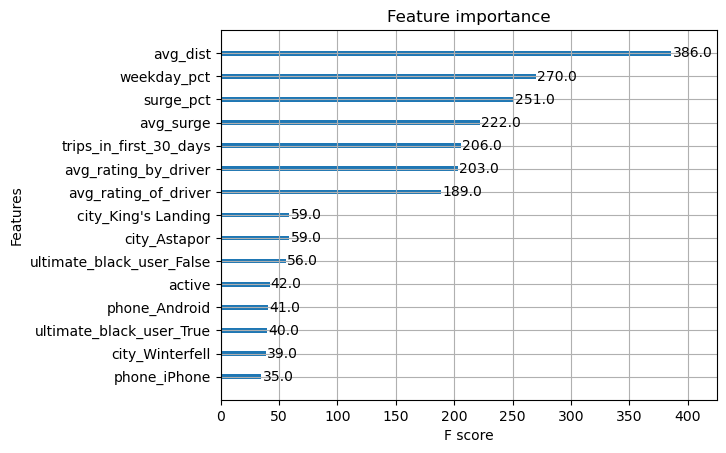

In [126]:
xgb.plot_importance(grid_search.best_estimator_)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

In [163]:
import shap
#this package will give us a better idea of what features have a positive or negative impact on classifier model

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [164]:
#extracting important features using shap package
explainer=shap.Explainer(grid_search.best_estimator_)
shap_values=explainer(X_train)
np.shape(shap_values.values)

(25634, 15)

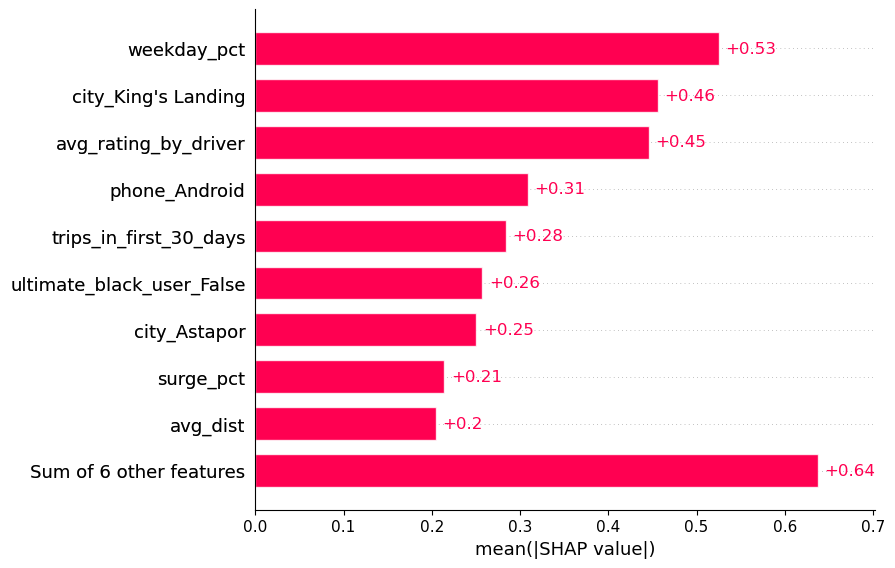

In [165]:
#feature importance
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


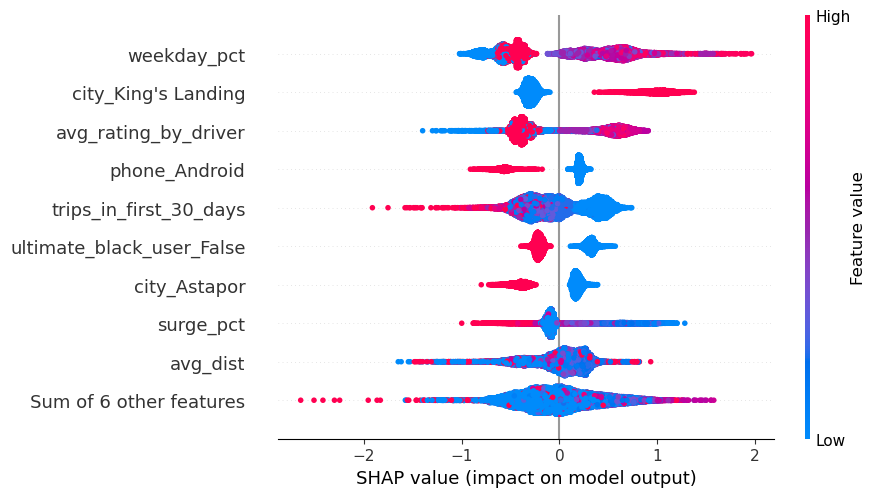

In [166]:
#Beeswarm plot to plot each SHAP value for each feature and their respective feature value. 
shap.plots.beeswarm(shap_values)

Things that we can draw from this:
1. Weekday pct (usage during the week) has the top feature from the model. This is interesting as could further investigate if this is due to businesses paying for their employees to ride? Convenience of those during the week?
2. Is there ways to capture clients on the weekends? Incentives? Looking at traffic patterns to see when people are out and make sure the supply is there for those times.
3. Making incentives to capture people to use the app/service in the first 30 days as shows to be a big indictor if retained in 6 months.
4. Look at specifically Android app version to see if there is something not user friendly that it gives a negative impact on the model. 